In [1]:
# #!pip install tf-nightly==2.5.0.dev20201111 -qqq --progress-bar off
# import tensorflow as tf
# print(tf.__version__)
# assert tf.__version__== '2.5.0-dev20201111','bad version'

In [2]:
cd /Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks

/Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks


In [17]:
%matplotlib inline
from datetime import datetime;now = datetime.now;t00 = now()
import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.mixture import BayesianGaussianMixture

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:00.139702


In [4]:
cd ../

/Users/aidasaglinskas/Desktop/BC-MRI-AE


In [5]:
def getCaseMatch(dx_idx,do_plot=False,control='non-familial-control'):
    ii = list()
    dfsc = dfs.copy();
    for dx_ind in range(sum(dx_idx)):
        dfsc = dfsc.set_index(np.arange(len(dfsc)))
        dx_age = dfsc['age_years'].values[dx_idx]
        dx_sex = dfsc['sex'].values[dx_idx]
        idxs = np.arange(len(dfs))
        v1 = dfsc['family_type'].values==control
        v2 = dfsc['sex'].values == dx_sex[dx_ind]
        v_dx = dfsc['clinical_asd_dx'].values !='1'
        
        v3 = abs(dfsc['age_years'].values[v1*v2*v_dx]-dx_age[dx_ind])

        match_arr = idxs[v1*v2][np.argsort(v3)]
        match_arr = np.array(match_arr)
        match_arr = match_arr[np.array([m not in ii for m in match_arr])]
        i = match_arr[0]
        ii.append(i)

    caseMatch_idx = ii
    caseMatch_idx.sort()
    caseMatch_idx
    assert len(caseMatch_idx)==len(np.unique(caseMatch_idx)),'non unique elements'
    if do_plot==True:
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.hist(dfs['sex'].values[caseMatch_idx],alpha=.3)
        plt.hist(dfs['sex'].values[dx_idx],alpha=.3)

        plt.subplot(1,3,2)
        plt.hist(dfs['age_years'].values[caseMatch_idx],alpha=.3)
        plt.hist(dfs['age_years'].values[dx_idx],alpha=.3)

        plt.subplot(1,3,3)
        plt.hist(dfs['family_type'].values[caseMatch_idx],alpha=.3)
        plt.hist(dfs['family_type'].values[dx_idx],alpha=.3)
        
    return caseMatch_idx

In [6]:
# get abide dataframe
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,AgeAtScan,...,WISC4 Pic Con Scaled,WISC4 Matrix Scaled,WISC4 Dig Span Scaled,WISC4 Let Num Scaled,WISC4 Coding Scaled,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Off stimulants at EPI scan?
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [7]:
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [8]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

In [9]:
batch_size = 32

TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:]
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:]

In [10]:
# get VAE
encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=2, batch_size=32, disentangle=False, gamma=1)
vae.load_weights('../tf_outputs/weights/lol');

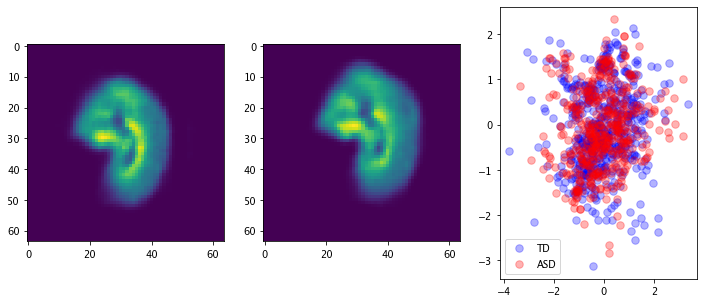

In [11]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(vae.predict(TD_batch)[0,32,:,:,0])
plt.subplot(1,3,2)
plt.imshow(decoder.predict(np.random.randn(3,2))[0,32,:,:,0])
plt.subplot(1,3,3)
arr = encoder.predict(ABIDE_data)[2]
plt.plot(arr[dxArr==1,0],arr[dxArr==1,1],'b.',markersize=15,alpha=.3)
plt.plot(arr[dxArr==2,0],arr[dxArr==2,1],'r.',markersize=15,alpha=.3)
plt.legend(['TD','ASD'])

In [12]:
cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D()
weights_fn = '../tf_outputs/3D_CCVAE_Weights/lol'
cvae.load_weights(weights_fn)

In [13]:
def project_data(data,dxArr,lbls):
    plt.figure(figsize=(12,4));
    plt.subplot(1,3,1);
    z_mean, z_log_var, z = z_encoder(data[:,:,:,:]);
    x = z;
    x = np.array(x);
    mark = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.','b*', 'g*', 'r*', 'c*', 'm*', 'y*', 'k*','bx', 'gx', 'rx', 'cx', 'mx', 'yx', 'kx']
    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    plt.legend(lbls);
    plt.title('CAE background');

    plt.subplot(1,3,2)
    s_mean, s_log_var, s = s_encoder(data[:,:,:,:]);
    x = s;
    x = np.array(x);

    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    plt.legend(lbls);
    plt.title('CAE salient');

    plt.subplot(1,3,3);
    v_mean, v_log_var, v = encoder(data[:,:,:,:]);
    x = v;
    x = np.array(x);

    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    plt.legend(lbls);
    plt.title('VAE');
    
    if len(np.unique(dxArr))>1:
        plt.figure(figsize=(6,4));
        plt.bar([0,1,2],[silhouette_score(z,dxArr),silhouette_score(s,dxArr),silhouette_score(v,dxArr)]);
        plt.xticks([0,1,2],labels=['CAE background','CAE salient','Vae']);
        plt.ylim(0,1)

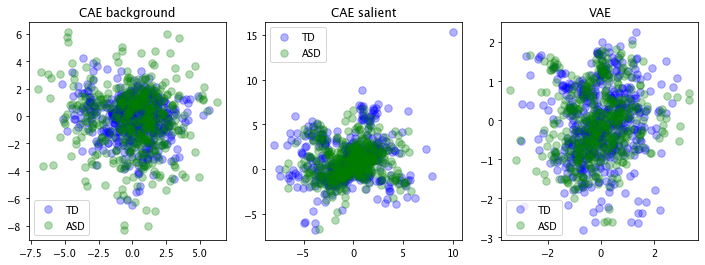

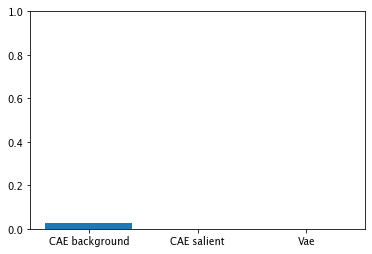

In [14]:
data = ABIDE_data;dxArr = dxArr;lbls = ['TD','ASD']
project_data(data,dxArr,lbls)

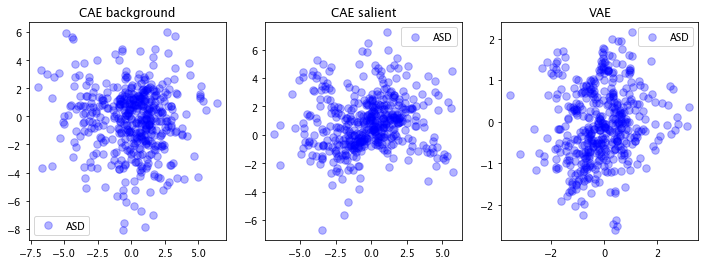

In [15]:
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']
project_data(data,dxArr,lbls)

In [19]:
encs = [z_encoder, s_encoder ,encoder]

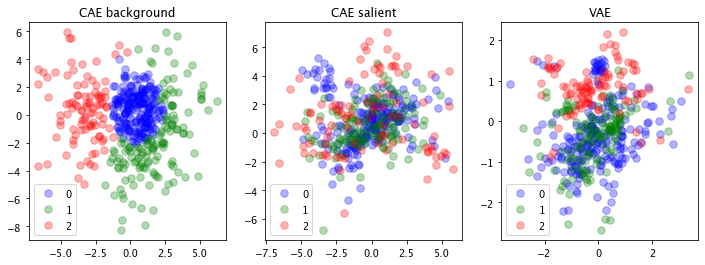

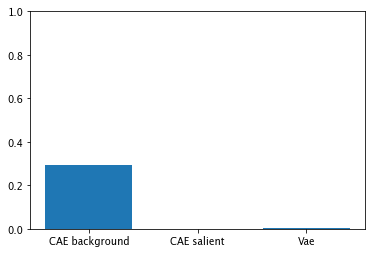

In [20]:
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[0](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

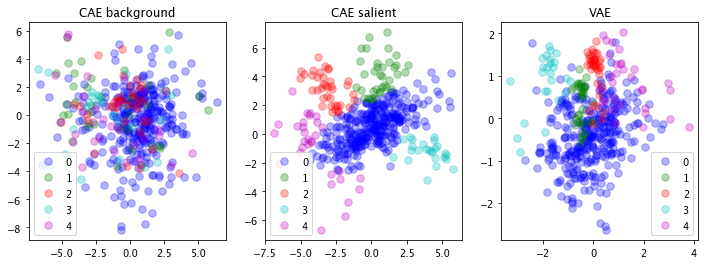

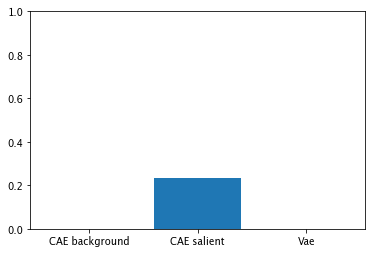

In [21]:
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[1](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

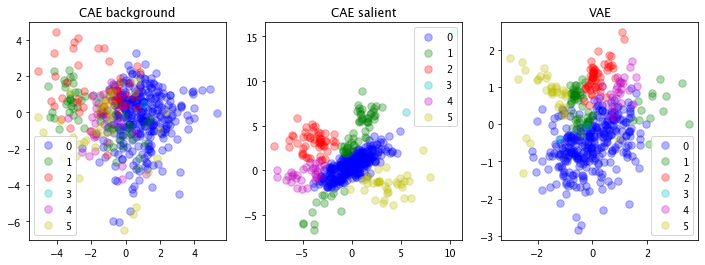

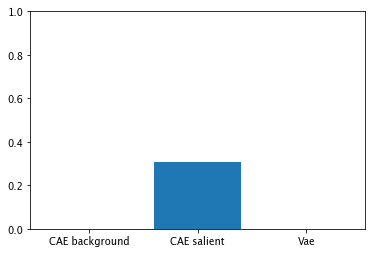

In [29]:
v = df['Subject Type'].values=='CONTROL'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[1](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

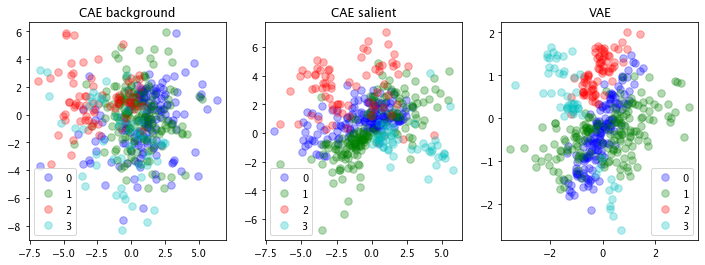

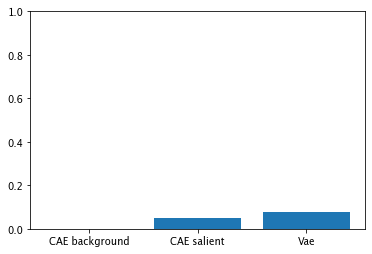

In [32]:
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[2](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

## SFARI

In [23]:
arr = np.load('./Data/SFARI-Anat-64iso.npz')
SFARI_data = arr['data']
SFARI_subs = arr['subs']
snsubs = SFARI_data.shape[0]
print(arr.files)
SFARI_data.shape

['data', 'subs']


(131, 64, 64, 64)

In [24]:
#dfs = pd.read_csv('./CSVs/SFARI-legend.csv')
dfs = pd.read_csv('./CSVs/DS-use.csv')
dfs = dfs.iloc[np.array([l in SFARI_subs for l in dfs['BIDS ID'].values])]

In [25]:
assert all([dfs['BIDS ID'].values[i]==SFARI_subs[i] for i in range(snsubs)]),'badness'
assert len(dfs)==len(SFARI_subs),'bad coder, bad!'

In [26]:
# SLICE: Only Keep 16p and TD
ugene = ['non-familial-control','16p-duplication','16p-deletion']
slice_arr = np.array([val in ugene for val in dfs['family_type'].values])

dfs = dfs.iloc[slice_arr]
snsubs = len(dfs)
SFARI_data = SFARI_data[slice_arr,:,:,:]
SFARI_subs = SFARI_subs[slice_arr]
print(snsubs)

121


In [27]:
dfs.head()

,BIDS ID,SVIP ID,FCAP1,SCAP1,SCAP2,family_type,genetic_status_16p,svip_diagnosis_m1,ados_css,ados_module,...,relationship_to_iip,rrb_css,sa_css,sex,svip_neuro_exam.background.head_circum,svip_neuro_exam.background.head_circum_perc,svip_neuro_exam.background.head_circum_z_score,svip_neuro_exam.measure.eval_age_months,svip_neuro_exam.measure.measure_type,age_years
0,sub-004,14705.x14,14705.x14_50_FCAP1,14705.x14_40_SCAP1,[],16p-duplication,duplication,no-diagnosis,2,ados-4,...,Mother,1,2,female,[],[],[],405,svip-neuro-exam,34
1,sub-008,14708.x10,14708.x10_60_FCAP1,14708.x10_40_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,2,ados-3,...,Initially identified proband,1,3,female,54.8,[],2.08,113,svip-neuro-exam,9
2,sub-012,14713.x7,14713.x7_50_FCAP1,14713.x7_30_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,6,ados-3,...,Initially identified proband,5,7,male,55.2,[],2.28,87,svip-neuro-exam,7
3,sub-014,14714.x18,14714.x18_60_FCAP1,14714.x18_40_SCAP1,[],16p-deletion,deletion,no-diagnosis,2,ados-4,...,Initially identified proband,6,2,male,55.8,[],0.49,249,svip-neuro-exam,21
4,sub-018,14718.x5,14718.x5_50_FCAP1,14718.x5_20_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,1,ados-3,...,Initially identified proband,1,1,female,54,[],1.15,127,svip-neuro-exam,11


In [33]:
geneVec = np.repeat(0,snsubs)
geneVec[dfs['family_type'].values==ugene[0]]=1
geneVec[dfs['family_type'].values==ugene[1]]=2
geneVec[dfs['family_type'].values==ugene[2]]=3

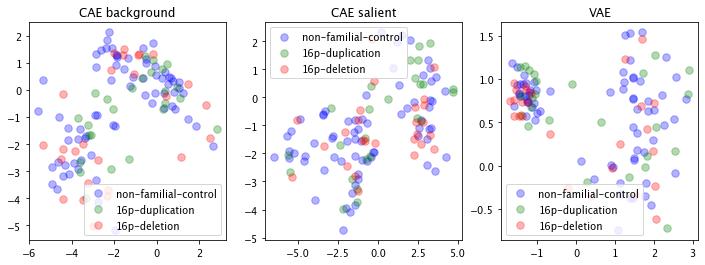

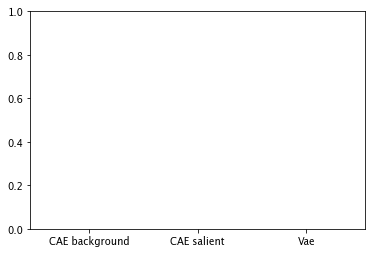

In [139]:
data = SFARI_data
dxArr = geneVec
lbls = ugene
project_data(data,dxArr,lbls)

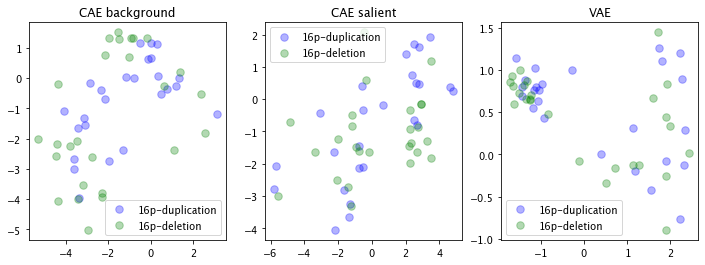

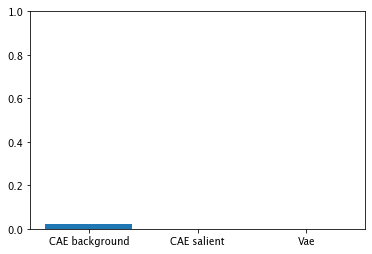

In [144]:
d = np.array([val in [2,3] for val in geneVec])
data = SFARI_data[d,:,:,:]
dxArr = geneVec[d]
lbls = ugene[1::]
project_data(data,dxArr,lbls)

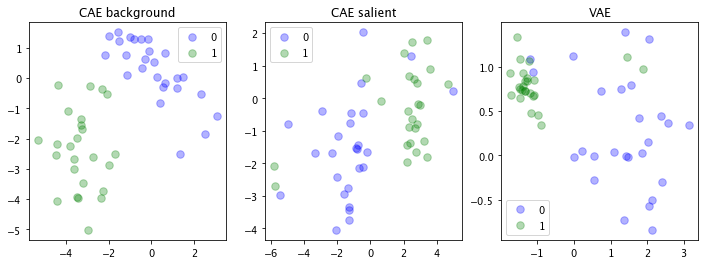

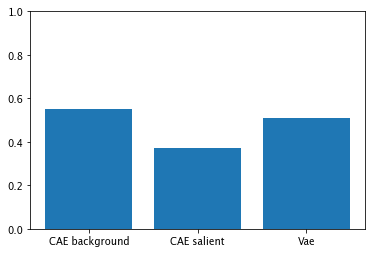

In [145]:
d = np.array([val in [2,3] for val in geneVec])
data = SFARI_data[d,:,:,:]
dxArr = geneVec[d]
lbls = ugene[1::]

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid = bnpc.fit_predict(np.array(encs[0](data)[2]))

lbls = [str(u) for u in np.unique(cid)];
dxArr = cid
project_data(data,dxArr=cid,lbls=lbls)

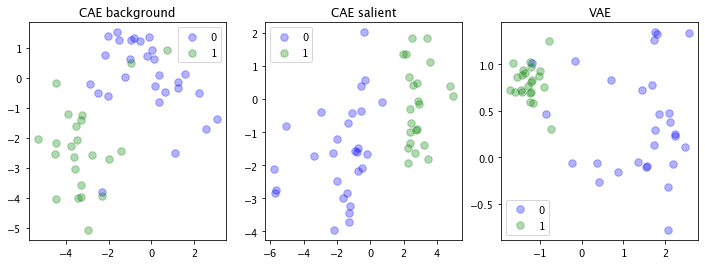

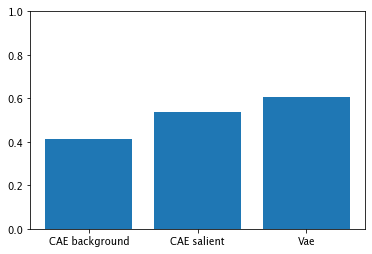

In [150]:
d = np.array([val in [2,3] for val in geneVec])
data = SFARI_data[d,:,:,:]
dxArr = geneVec[d]
lbls = ugene[1::]

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid = bnpc.fit_predict(np.array(encs[1](data)[2]))

lbls = [str(u) for u in np.unique(cid)];
dxArr = cid
project_data(data,dxArr=cid,lbls=lbls)

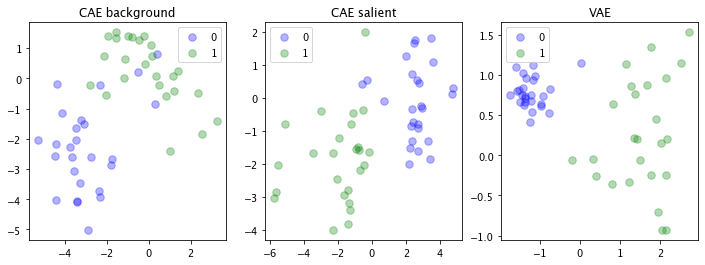

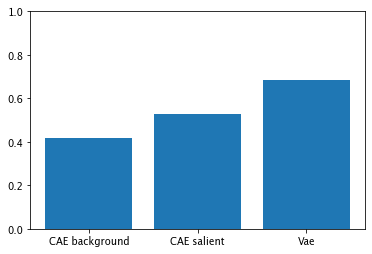

In [38]:
d = np.array([val in [2,3] for val in geneVec])
data = SFARI_data[d,:,:,:]
dxArr = geneVec[d]
lbls = ugene[1::]

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid = bnpc.fit_predict(np.array(encs[2](data)[2]))

lbls = [str(u) for u in np.unique(cid)];
dxArr = cid
project_data(data,dxArr=cid,lbls=lbls)

## SFARI CASE MATCHED

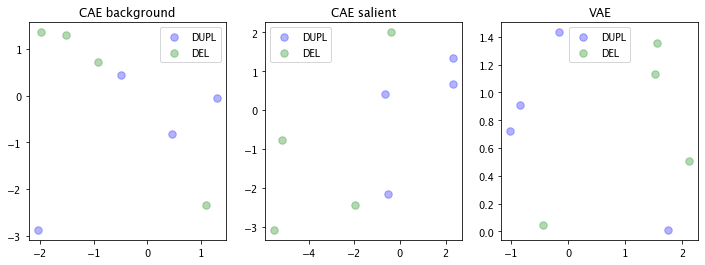

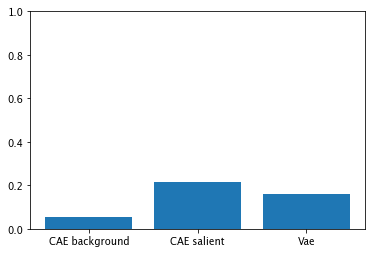

In [132]:
dd = np.zeros(snsubs)
v1 = dfs['family_type'].values=='16p-duplication'
v2 = dfs['age_years'].values < 10
targ = v1*v2
ccidx = np.array(getCaseMatch(targ,do_plot=False,control='16p-deletion'))
dd[targ]=1;dd[np.array(ccidx)]=2;d = dd!=0
project_data(SFARI_data[d,:,:,:],dd[d],['DUPL','DEL'])

(0.0, 1)

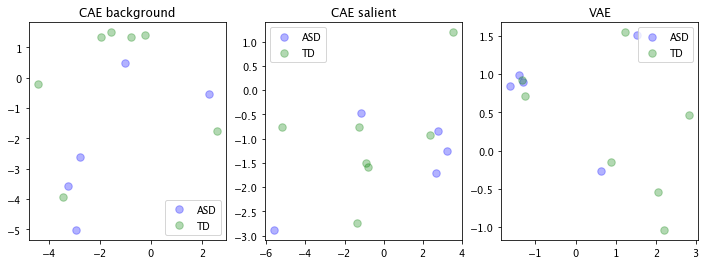

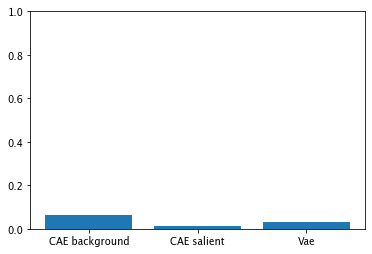

In [137]:
dd = np.zeros(snsubs)
v1 = dfs['clinical_asd_dx'].values=='1'
v2 = dfs['age_years'].values < 10
targ = v1
ccidx = np.array(getCaseMatch(targ,do_plot=False,control=ugene[2]))
dd[targ]=1;dd[np.array(ccidx)]=2;d = dd!=0
project_data(SFARI_data[d,:,:,:],dd[d],['ASD','TD']);plt.ylim(.0,1)